#Group 11 project 1
  Group members:
  - Jennifer Becerra
  - Sierra Landacre
  - Don Krapohl


  Our proposal is at https://docs.google.com/document/d/13be3PvzDU99-EkooqcpcbDVWiMm37aB0SOlEGFb2J7U/edit?tab=t.0

  Summary:  This data analysis group project will use basic deep learning techniques and algorithms to predict the probability of the five most widespread COVID-19 variants in each country based on societal and infrastructure information.

  Citations
  - Franceschini, L. (2024, April). The World Factbook by CIA, Version 4. Retrieved 01/29/2025 from https://www.kaggle.com/datasets/lucafrance/the-world-factbook-by-cia

  - Giordano, D, SARS-CoV-2-Variants, (2022), GitHub repository, https://github.com/3dgiordano/SARS-CoV-2-Variants.


**Mount Google Drive**

In [ ]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import Libraries**

In [ ]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import os
import glob
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

**Define Paths**

In [ ]:
# Set Up File Paths
standard_colab_google_mount = "/content/drive"
base_path = "/content/drive/MyDrive/project1_data/"
country_data_path = f"{base_path}country_data/"
country_data_file_path = f"{country_data_path}countries.csv"
covid_data_path = f"{base_path}SARS-CoV-2-Variants/"


**Define Preprocessing Models**

In [ ]:
variant_encoder = LabelEncoder()
country_encoder = LabelEncoder()
country_metric_scaler = StandardScaler()
covid_date_scaler = MinMaxScaler()
ohe_variant = OneHotEncoder()

**Load Country Data**

In [ ]:
# Load country data
country_df = pd.read_csv(country_data_file_path)

# Keep only specific columns
country_cols_to_keep = [
    'Country',
    'Environment: Urbanization - urban population',
    'People and Society: Hospital bed density',
    'People and Society: Obesity - adult prevalence rate'
]
country_df = country_df[country_cols_to_keep]

print("Country data loaded and filtered successfully.")
print(country_df.head())




Country data loaded and filtered successfully.
         Country Environment: Urbanization - urban population  \
0  United States             83.3% of total population (2023)   
1    Afghanistan             26.9% of total population (2023)   
2       Akrotiri                                          NaN   
3        Albania             64.6% of total population (2023)   
4        Algeria             75.3% of total population (2023)   

  People and Society: Hospital bed density  \
0         2.9 beds/1,000 population (2017)   
1         0.4 beds/1,000 population (2017)   
2                                      NaN   
3         2.9 beds/1,000 population (2013)   
4         1.9 beds/1,000 population (2015)   

  People and Society: Obesity - adult prevalence rate  
0                                       36.2% (2016)   
1                                        5.5% (2016)   
2                                                NaN   
3                                       21.7% (2016)   
4    

**Combine COVID Data Files Using Glob**

In [ ]:
# Use glob to find all CSV files in the directory
csv_files = glob.glob(os.path.join(covid_data_path, '*.csv'))

# Initialize an empty DataFrame to store combined data
combined_df = pd.DataFrame()

# Loop through the list of CSV files and concatenate them
for file in csv_files:
  try:
    df = pd.read_csv(file)

    # ------------------ prep for finding the largest covid variant in the row -----------
    # We have to make the covid variant data numeric, fill Na, etc.
    numeric_cols = df.columns.difference(['location', 'date'])     # consider everything else numerical
    df.fillna(0, inplace=True)                                     # fill in zeroes
    df.replace('NaN', "0", inplace=True)                           # fix NaNs for now

    # Numbers are in #,# format. We'd like floating-point #.# format so fix them
    for col in df.columns:
        if col in numeric_cols:
            try:
                # If we can replace a comma, do it and retype the dtype
                df[col] = df[col].str.replace(',', '.').astype(float)
            except:
                continue  # Ignore errors

    # Fill missing values with 0.0
    df = df.fillna(0.0)

    # Compute highest variant column efficiently
    highest_variant_series = df[numeric_cols].idxmax(axis=1)

    # Avoiding fragmentation by using pd.concat"
    df = pd.concat([df, highest_variant_series.rename('HighestVariant')], axis=1)

    # Getting the variant down to the base version
    # this removes values "cases" and "mob_idx"
    # the rest of the values are stripped to their base variant ("B", "Omicron", etc., or "Unknown")
    df['HighestVariant'] = df['HighestVariant'].astype(str).apply(lambda x: 'Unknown' if x.split("-", 1)[0]
                                                                              .split(" ", 1)[0].strip() in ['cases', 'mob_idx']
                                        else x.split("-", 1)[0].split(" ", 1)[0].split(".", 1)[0].strip())

    # we'll reduce the number of classes by changing everything not in variants_to_keep to "Other"
    variants_to_keep = ['Omicron', 'B', 'Delta','Alpha']
    # Replace values not in the list with "Other"
    df["HighestVariant"] = df["HighestVariant"].where(df["HighestVariant"].isin(variants_to_keep), "Other")

    # Select only location, date, and HighestVariant
    df_subset = df[['location', 'date', 'HighestVariant']].copy()

    # append to the dataset
    # Also unfragment the DataFrame; we've been doing a lot of column manipulation
    combined_df = pd.concat([combined_df, df_subset], ignore_index=True).loc[:, :].copy()

  except pd.errors.EmptyDataError:
      print(f"Empty data error for file: {file}")
  except Exception as e:
      print(f"An error occurred for file: {file}, {e}")
      print(e)


print("COVID data loaded and combined successfully.")
print(combined_df.head(25))
print(f"Total number of rows: {combined_df.shape[0]}")
print(f"Total number of columns: {combined_df.shape[1]}")







Empty data error for file: /content/drive/MyDrive/project1_data/SARS-CoV-2-Variants/Macao.csv
An error occurred for file: /content/drive/MyDrive/project1_data/SARS-CoV-2-Variants/variants.csv, '>' not supported between instances of 'str' and 'int'
'>' not supported between instances of 'str' and 'int'
COVID data loaded and combined successfully.
   location        date HighestVariant
0   Austria  2020-03-08              B
1   Austria  2020-03-22              B
2   Austria  2020-04-05              B
3   Austria  2020-04-19              B
4   Austria  2020-05-03              B
5   Austria  2020-05-17              B
6   Austria  2020-05-31              B
7   Austria  2020-06-14              B
8   Austria  2020-06-28              B
9   Austria  2020-07-12              B
10  Austria  2020-07-26              B
11  Austria  2020-08-09              B
12  Austria  2020-08-23              B
13  Austria  2020-09-06              B
14  Austria  2020-09-20              B
15  Austria  2020-10-04     

**Process Data**

In [ ]:
combined_df.head(10)

,location,date,HighestVariant
0,Austria,2020-03-08,B
1,Austria,2020-03-22,B
2,Austria,2020-04-05,B
3,Austria,2020-04-19,B
4,Austria,2020-05-03,B
5,Austria,2020-05-17,B
6,Austria,2020-05-31,B
7,Austria,2020-06-14,B
8,Austria,2020-06-28,B
9,Austria,2020-07-12,B


**Show Relative Class Counts**

In [ ]:
# Get unique values and their counts for 'col1'
print(combined_df['HighestVariant'].value_counts())

HighestVariant
Omicron    3975
B          2969
Delta      2021
Alpha       981
Other       882
Name: count, dtype: int64


***Convert Columns to Strings and Merge Dataframes**

In [ ]:

# Merge dataframes on a common column (e.g., 'Country' and 'location')
merged_df = pd.merge(country_df, combined_df, left_on='Country', right_on='location')
print("Data combined successfully.")
print(merged_df.head(5))

# Make copies so we can do work without affecting the original
local_merged_df = merged_df.copy()

Data combined successfully.
         Country Environment: Urbanization - urban population  \
0  United States             83.3% of total population (2023)   
1  United States             83.3% of total population (2023)   
2  United States             83.3% of total population (2023)   
3  United States             83.3% of total population (2023)   
4  United States             83.3% of total population (2023)   

  People and Society: Hospital bed density  \
0         2.9 beds/1,000 population (2017)   
1         2.9 beds/1,000 population (2017)   
2         2.9 beds/1,000 population (2017)   
3         2.9 beds/1,000 population (2017)   
4         2.9 beds/1,000 population (2017)   

  People and Society: Obesity - adult prevalence rate       location  \
0                                       36.2% (2016)   United States   
1                                       36.2% (2016)   United States   
2                                       36.2% (2016)   United States   
3               

In [ ]:
merged_df["HighestVariant"].value_counts()

,count
HighestVariant,
Omicron,3596
B,2633
Delta,1803
Alpha,859
Other,798


**Do Train/Test Split**

In [ ]:
X = local_merged_df.drop(['HighestVariant'],axis=1)     # remove our target variable
y = local_merged_df['HighestVariant']                   # make a y axis from it
X_train, X_test_raw, y_train, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test_raw.shape}")
print(f"Shape of y_test: {y_test_raw.shape}")

Shape of X_train: (7751, 6)
Shape of y_train: (7751,)
Shape of X_test: (1938, 6)
Shape of y_test: (1938,)


**Do Encoding and Scaling**

In [ ]:
# define a reusable preprocessor we can use again on the test data later
def do_preproc(X_features_in, y_target_variable_in, transform_only):
  '''
    parameters:
      X_features: the X series in its raw incoming format to apply transforms to
      y_targer_variable: the y series we'll have as our prediction target
      transform_only: True/False, for training we want to fit_transform models.
            for test data we only want to transform using the fit we made in training.
  '''

  # make copies so we aren't modifying the original data. Allows us to re-run code blocks
  X_features = X_features_in.copy()
  y_target_variable = y_target_variable_in.copy()

  if transform_only:
    y_target_variable = ohe_variant.transform(y_target_variable.values.reshape(-1, 1)).toarray()
  else:
    y_target_variable = ohe_variant.fit_transform(y_target_variable.values.reshape(-1, 1)).toarray()

  # -------------------------------- label/string encoding ------------------------
  # Perform label encoding on the 'Country' column
  if transform_only:
    X_features['Country'] = country_encoder.transform(X_features['Country'])
  else:
    X_features['Country'] = country_encoder.fit_transform(X_features['Country'])

  # Perform label encoding on the 'HighestVariant' column
  #X_features['HighestVariant'] = variant_encoder.fit_transform(X_features['HighestVariant'])

  # encoder may not have all the countries in the covid list so impute missing
  X_features['location'] = X_features['location'].map(lambda s: '<unknown>' if s not in country_encoder.classes_ else s)
  country_encoder.classes_ = np.append(country_encoder.classes_, '<unknown>')

  # Now do it on the COVID 'location' column
  X_features['location'] = country_encoder.transform(X_features['location'])

  print("Label encoding completed.")
  # ------------------------------------------------------------------------------

  # -------------------------------- numerical scaling-----------------------------
  # renaming the columns for addressing more easily
  X_features = X_features.rename(columns={'Environment: Urbanization - urban population': 'UrbanPop',
                'People and Society: Hospital bed density':'HospBedDensity',
                'People and Society: Obesity - adult prevalence rate':'Obesity'})

  # scale the date in the COVID dataset
  X_features['date'] = X_features['date'].str.replace('-','').apply(int)
  if transform_only:
    X_features['date'] = covid_date_scaler.transform(X_features[['date']])
  else:
    X_features['date'] = covid_date_scaler.fit_transform(X_features[['date']])


  numeric_regex = "(\d+(\.\d+)?)"
  X_features['UrbanPop'] = X_features['UrbanPop'].str.extract(numeric_regex)[0].fillna(0).astype(float)
  X_features['HospBedDensity'] = X_features['HospBedDensity'].str.extract(numeric_regex)[0].fillna(0).astype(float)
  X_features['Obesity'] = X_features['Obesity'].str.extract(numeric_regex)[0].fillna(0).astype(float)

  # Clean numerical columns
  numerical_columns = [
      'UrbanPop',
      'HospBedDensity',
      'Obesity'
  ]


  print("Numerical columns cleaned and renamed.")
  print(X_features[numerical_columns].head())

  # Perform data normalization on numerical columns
  if transform_only:
    X_features[numerical_columns] = country_metric_scaler.transform(X_features[numerical_columns])
  else:
    X_features[numerical_columns] = country_metric_scaler.fit_transform(X_features[numerical_columns])


  print("Data normalization completed.")
  print(X_features.head())
  return X_features, y_target_variable

# we'll now use the preprocessor on the training data

X_train, y_train = do_preproc(X_train, y_train, transform_only = False) # we want to fit_transform

Label encoding completed.
Numerical columns cleaned and renamed.
      UrbanPop  HospBedDensity  Obesity
8039     100.0             2.5      6.1
1354      87.8             2.1     22.1
5229      14.6             0.0      0.0
3985      36.4             0.5      3.9
1794     100.0             0.0      0.0
Data normalization completed.
      Country  UrbanPop  HospBedDensity   Obesity  location      date
8039      158  1.499783       -0.078458 -1.219866       158  0.674976
1354       25  0.959398       -0.244398  0.392188        25  0.675903
5229      102 -2.282912       -1.115583 -1.834462       102  0.688317
3985       80 -1.317306       -0.908158 -1.441524        80  0.009700
1794       34  1.499783       -1.115583 -1.834462        34  0.029530


In [ ]:
X_train.head(1)

,Country,UrbanPop,HospBedDensity,Obesity,location,date
8039,158,1.499783,-0.078458,-1.219866,158,0.674976


**Preprocess Data and Save File**

In [ ]:
# Save Preprocessed Data

# Save the preprocessed data to a CSV file
X_train.to_csv('/content/drive/MyDrive/project1_data/preprocessed_data.csv', index=False)
print("Preprocessed data saved successfully.")



Preprocessed data saved successfully.


**Process the Test Data**

## Model Building
The data are ready to input into a model

**Feedforward Neural Network**

**Import Libraries**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Input, BatchNormalization, LeakyReLU
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
%matplotlib inline

**Configure Early Stopping**

In [ ]:

early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor loss
    patience=8,         # no improvement in N epochs, stop
    restore_best_weights=True,  # restore the best weights
    mode='max'           # 'min' for loss, 'max' for accuracy
)

**Build the Model**

In [ ]:
# Build the model

model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))  # x.shape[1] has count of input features.

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01))) # relu with L2 regularization
model.add(BatchNormalization())   # Stabilize training between layers
model.add(LeakyReLU(alpha=0.01))  # Allow small negative weights
model.add(Dropout(0.3))  # Dropout with 20% rate

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())   # Stabilize training between layers
model.add(LeakyReLU(alpha=0.01))  # Allow small negative weights
model.add(Dropout(0.3))  # Dropout with 20% rate

model.add(Dense(64, activation='relu'))
model.add(Dense(pd.DataFrame(y_train).shape[1], activation='softmax'))  # Adjust activation based on your target

# Print the model summary
model.summary()

# Set the learning rate on the adam optimizer
optimizer = Adam(learning_rate=0.0005)  # Lower learning rate

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=200, batch_size=128, validation_split=0.2, callbacks=[early_stopping])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 128)                 │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,013 (105.52 KB)

 Trainable params: 26,501 (103.52 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.2742 - loss: 1.8686 - val_accuracy: 0.3482 - val_loss: 1.6253
Epoch 2/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3429 - loss: 1.6914 - val_accuracy: 0.3121 - val_loss: 1.5869
Epoch 3/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3593 - loss: 1.6181 - val_accuracy: 0.3565 - val_loss: 1.5575
Epoch 4/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3616 - loss: 1.5835 - val_accuracy: 0.3862 - val_loss: 1.5477
Epoch 5/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3849 - loss: 1.5321 - val_accuracy: 0.3772 - val_loss: 1.5307
Epoch 6/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4244 - loss: 1.4756 - val_accuracy: 0.3972 - val_loss: 1.5313
Epoch 7/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4794 - loss: 1.3675 - val_accuracy: 0.4591 - val_loss: 1.4731
Epoch 8/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5044 - loss: 1.2780 - val_accuracy: 0.5564 -

**Create and Use an Evaluation Function**

In [ ]:
# this method will output model metrics and a confusion matrix
def eval_model(X_in, y_in):
  # Evaluate the model
  model_score = model.evaluate(X_in, y_in, verbose=0)
  predict_x = model.predict(X_in)
  y_pred = np.argmax(predict_x, axis=1)
  y_true = np.argmax(y_in, axis=1)  # Convert one-hot to class labels
  precision = precision_score(y_true, y_pred, average='macro')
  recall = recall_score(y_true, y_pred, average='macro')
  cm = confusion_matrix(y_true, y_pred)

  print(f"Model evaluation - Loss: {model_score[0]}, Accuracy: {model_score[1]}")

  print( 'precision = ' + str(precision) + '\nrecall = ' + str(recall))
  print('Confusion matrix on training data:\n- x-axis is true labels.\n- y-axis is predicted labels')
  print(pd.DataFrame(cm).head(6))

# call it for this model but we'll reuse the method later
eval_model(X_train, y_train)
tuned_ann_score = model.evaluate(X_train, y_train, verbose=0)

243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model evaluation - Loss: 1.6667811870574951, Accuracy: 0.3514385223388672
precision = 0.12665800826766369
recall = 0.19699126410576334
Confusion matrix on training data:
- x-axis is true labels.
- y-axis is predicted labels
   0    1  2     3  4
0  0  112  0   569  0
1  0  307  0  1804  0
2  0  226  0  1210  0
3  0  462  0  2417  0
4  0   42  0   602  0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Visualize the Model**

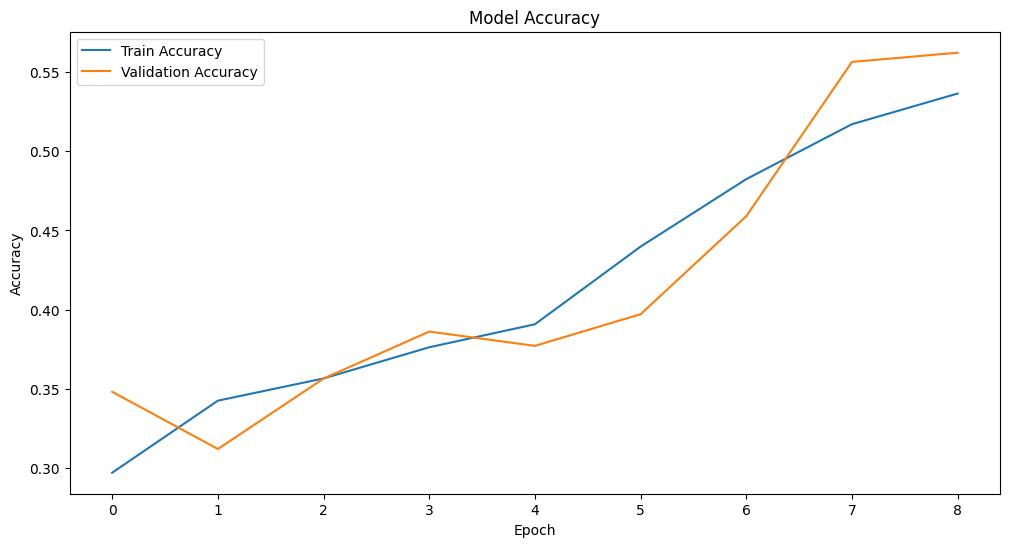

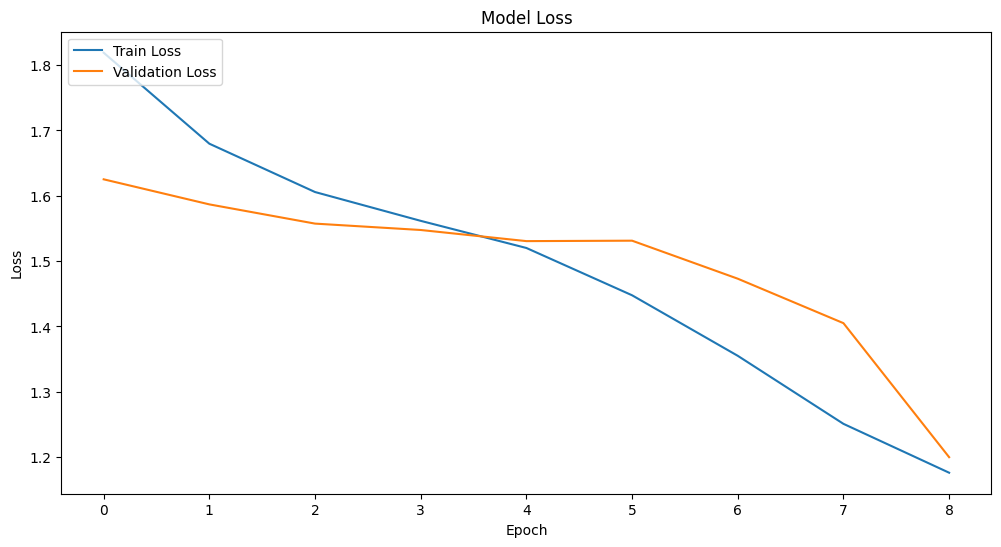

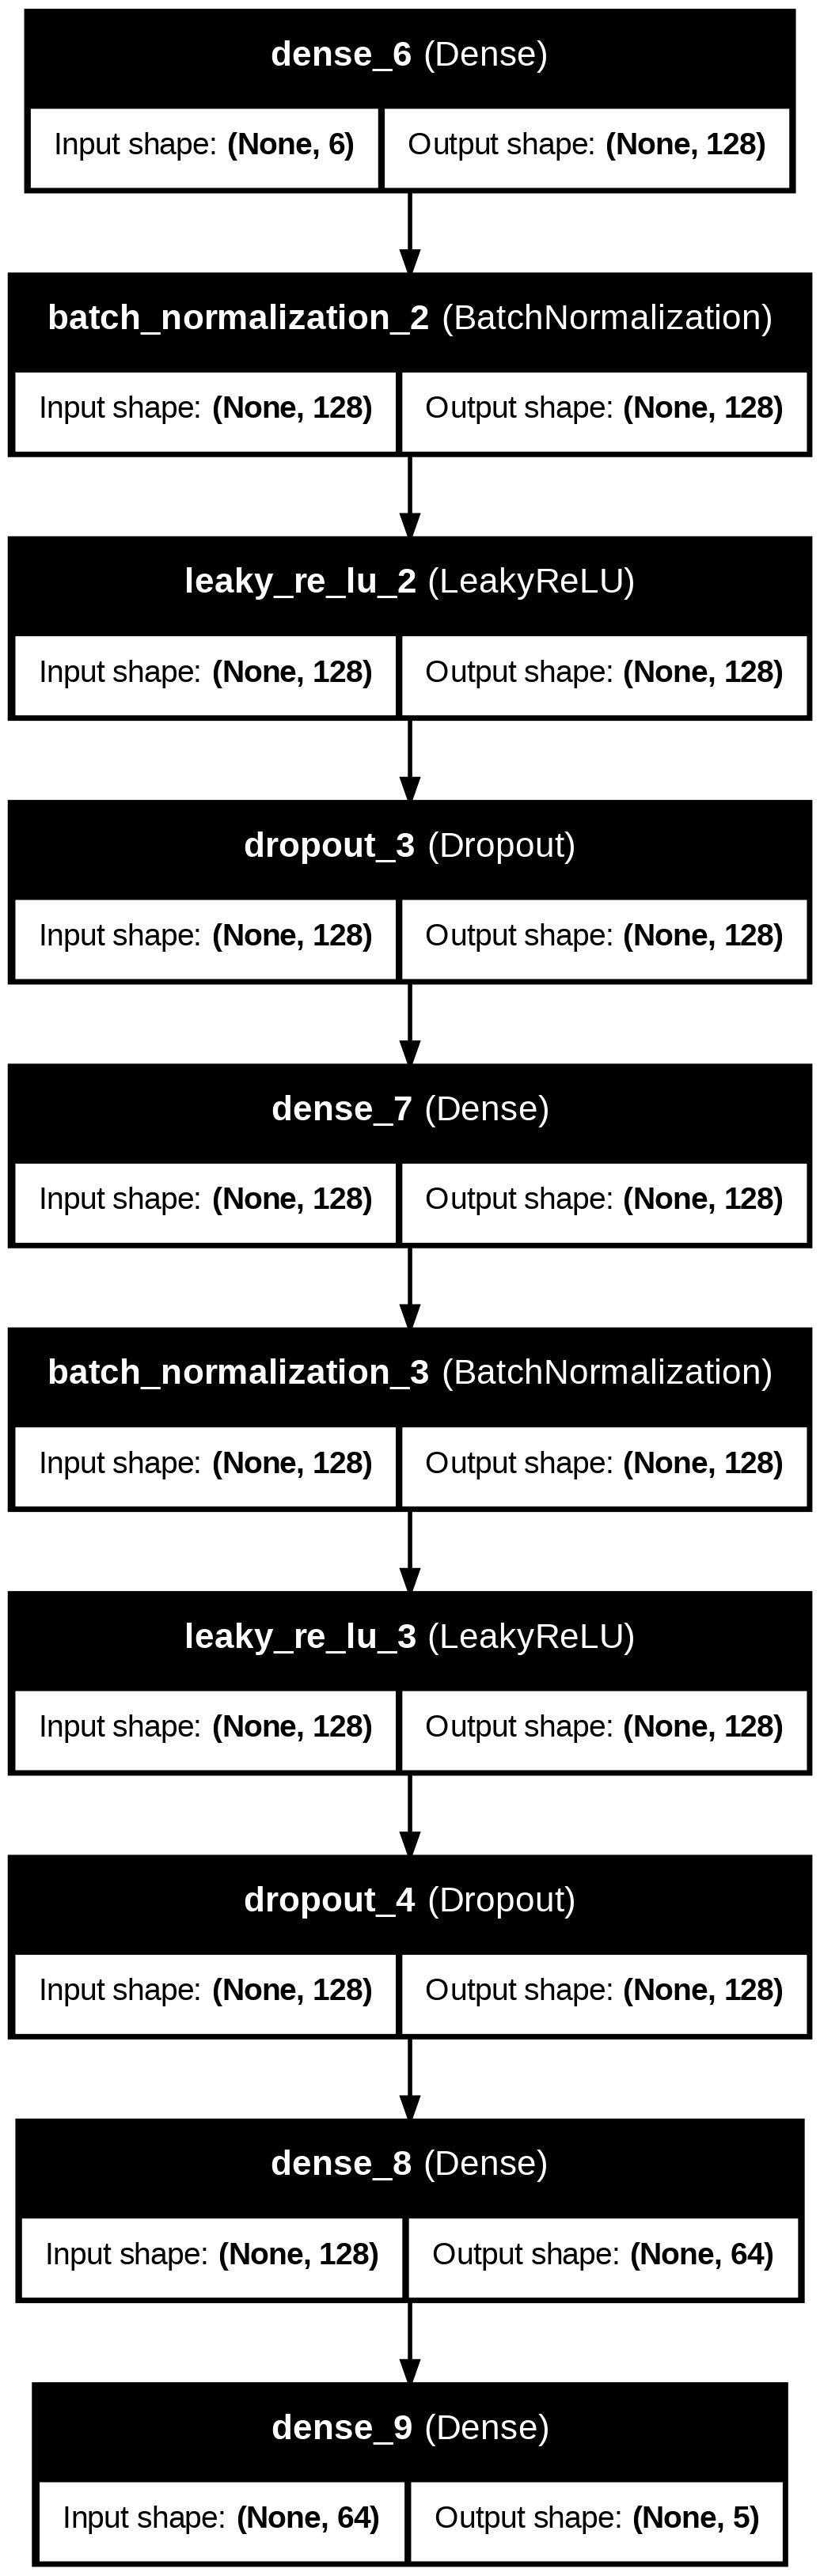

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Visualize the model architecture
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Display the model plot
Image(filename='model.png')


**RNN with LSTM MODEL**

In [ ]:
print(X_train.head(1))

      Country  UrbanPop  HospBedDensity   Obesity  location      date
8039      158  1.499783       -0.078458 -1.219866       158  0.674976


**Build the RNN with LSTM Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ReduceLROnPlateau

# reshape X_train for LSTM
X_train_LSTM = X_train.to_numpy(dtype=np.float32)
X_train_LSTM = X_train_LSTM.reshape((X_train.shape[0], 1, X_train.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train_LSTM.shape[0], 6), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(pd.DataFrame(y_train).shape[1], activation='softmax'))  # getting the number of unique classes in y

# Print the model summary
model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 7751, 128)           │          69,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 7751, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,773 (471.77 KB)

 Trainable params: 120,773 (471.77 KB)

 Non-trainable params: 0 (0.00 B)

**Train the RNN with LSTM Model**

In [ ]:
# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model and save the history
history = model.fit(X_train_LSTM, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])


Epoch 1/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.3568 - loss: 1.4991 - val_accuracy: 0.3714 - val_loss: 1.4462 - learning_rate: 0.0010
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3741 - loss: 1.4537 - val_accuracy: 0.3714 - val_loss: 1.4182 - learning_rate: 0.0010
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4571 - loss: 1.3490 - val_accuracy: 0.6402 - val_loss: 0.8622 - learning_rate: 0.0010
Epoch 4/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6136 - loss: 1.0055 - val_accuracy: 0.7544 - val_loss: 0.6857 - learning_rate: 0.0010
Epoch 5/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6698 - loss: 0.8932 - val_accuracy: 0.7286 - val_loss: 0.7132 - learning_rate: 0.0010
Epoch 6/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6844 - loss: 0.8323 - val_accuracy: 0.7698 - val_loss: 0.6361 - learning_rate: 0.0010
Epoch 7/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7175 - loss: 0.7613 

**Evaluate the RNN with LSTM Model**

Prepare the Test Data

In [ ]:
# encode and scale the test data
X_test, y_test = do_preproc(X_test_raw, y_test_raw, transform_only = True)  # we don't want to re-fit the data

# reshape X_train for LSTM. We did this same thing for X_train_LSTM so this has to match
X_test_LSTM = X_test.copy()
X_test_LSTM = X_test_LSTM.values.reshape((X_test_LSTM.shape[0], 1, X_test_LSTM.shape[1]))


Label encoding completed.
Numerical columns cleaned and renamed.
      UrbanPop  HospBedDensity  Obesity
2718      64.8             1.4     19.9
5344      92.1             4.3     22.6
1688      59.3             1.3     11.4
9318      84.6             2.5     27.8
39        83.3             2.9     36.2
Data normalization completed.
      Country  UrbanPop  HospBedDensity   Obesity  location      date
2718       51 -0.059360       -0.534793  0.170531        51  0.681895
5344      104  1.149862        0.668272  0.442565       104  0.361473
1688       32 -0.302977       -0.576278 -0.685873        32  0.674976
9318      183  0.817658       -0.078458  0.966483       183  0.364684
39        184  0.760076        0.087482  1.812811       184  0.350879


In [ ]:
print(X_test_LSTM[0])

[[51.         -0.0593604  -0.5347932   0.17053075 51.          0.68189493]]


In [ ]:
# Evaluate the model
LSTM_score = model.evaluate(X_test_LSTM, y_test, verbose=0)
print(f"Model evaluation - Loss: {LSTM_score[0]}, Accuracy: {LSTM_score[1]}")

Model evaluation - Loss: 0.5676912665367126, Accuracy: 0.7786377668380737


**Visualize Training History**

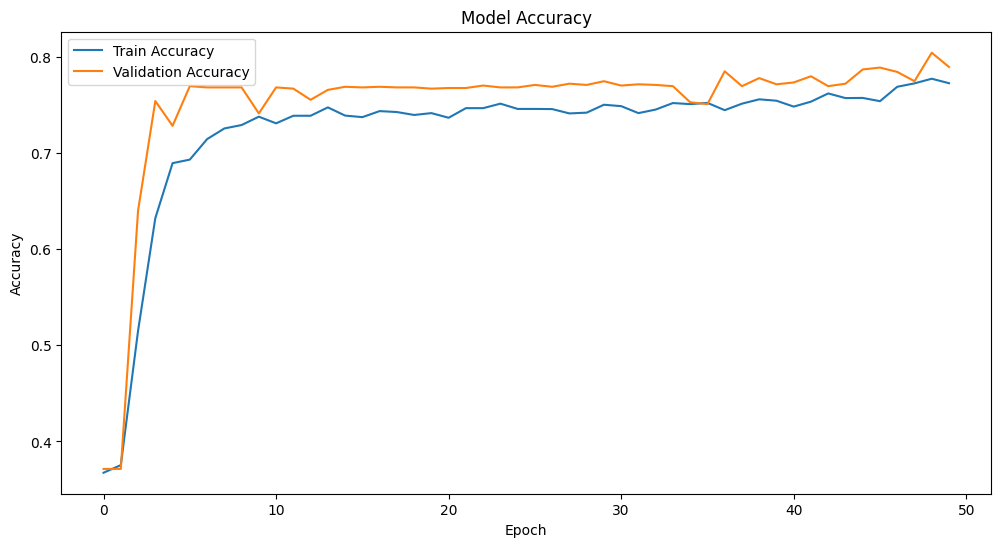

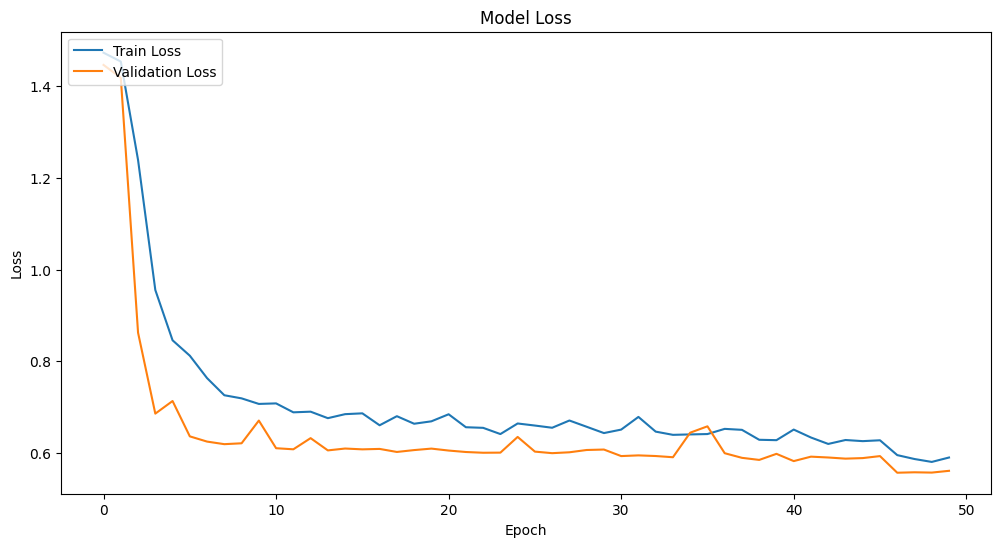

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


**Visualize Predictions vs. Actuals**

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


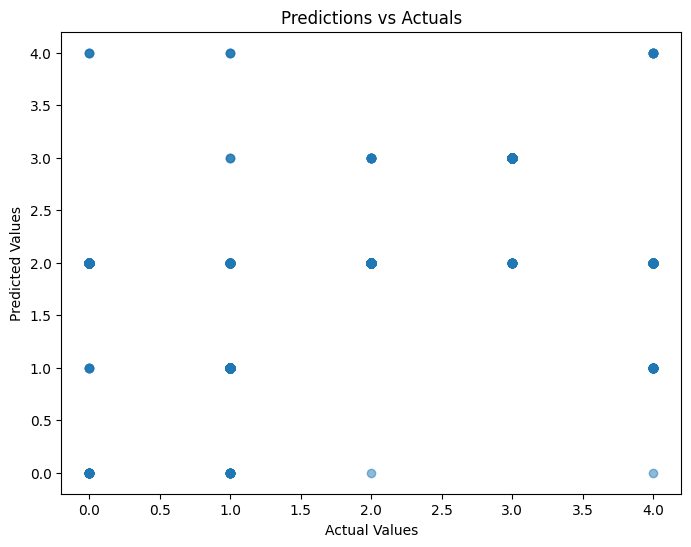

In [ ]:
# Scatter plot of predictions vs actuals
y_pred = model.predict(X_test_LSTM)
plt.figure(figsize=(8, 6))
plt.scatter(y_test.argmax(axis=1), y_pred.argmax(axis=1), alpha=0.5)
plt.title('Predictions vs Actuals')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


**GRNN MODEL**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Build the GRNN model
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))  # Input layer
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer

# Print the model summary
model.summary()

# Set the learning rate on the Adam optimizer
optimizer = Adam(learning_rate=0.0005)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model and save the history
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
grnn_score = model.evaluate(X_test, y_test, verbose=0)
print(f"Model evaluation - Loss: {grnn_score[0]}, Accuracy: {grnn_score[1]}")


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 128)                 │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,989 (101.52 KB)

 Trainable params: 25,989 (101.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2427 - loss: 5.9230 - val_accuracy: 0.3501 - val_loss: 1.5780 - learning_rate: 5.0000e-04
Epoch 2/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2730 - loss: 2.0093 - val_accuracy: 0.3101 - val_loss: 1.5827 - learning_rate: 5.0000e-04
Epoch 3/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3248 - loss: 1.6704 - val_accuracy: 0.3088 - val_loss: 1.5083 - learning_rate: 5.0000e-04
Epoch 4/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3430 - loss: 1.5797 - val_accuracy: 0.3714 - val_loss: 1.5012 - learning_rate: 5.0000e-04
Epoch 5/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3566 - loss: 1.5455 - val_accuracy: 0.3714 - val_loss: 1.4714 - learning_rate: 5.0000e-04
Model evaluation - Loss: 1.49161958694458, Accuracy: 0.36996904015541077


In [ ]:
# output model metrics
eval_model(X_train, y_train)

243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Model evaluation - Loss: 1.489666223526001, Accuracy: 0.3714359402656555
precision = 0.07428718874983872
recall = 0.2
Confusion matrix on training data:
- x-axis is true labels.
- y-axis is predicted labels
   0  1  2     3  4
0  0  0  0   681  0
1  0  0  0  2111  0
2  0  0  0  1436  0
3  0  0  0  2879  0
4  0  0  0   644  0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Visualize Model**

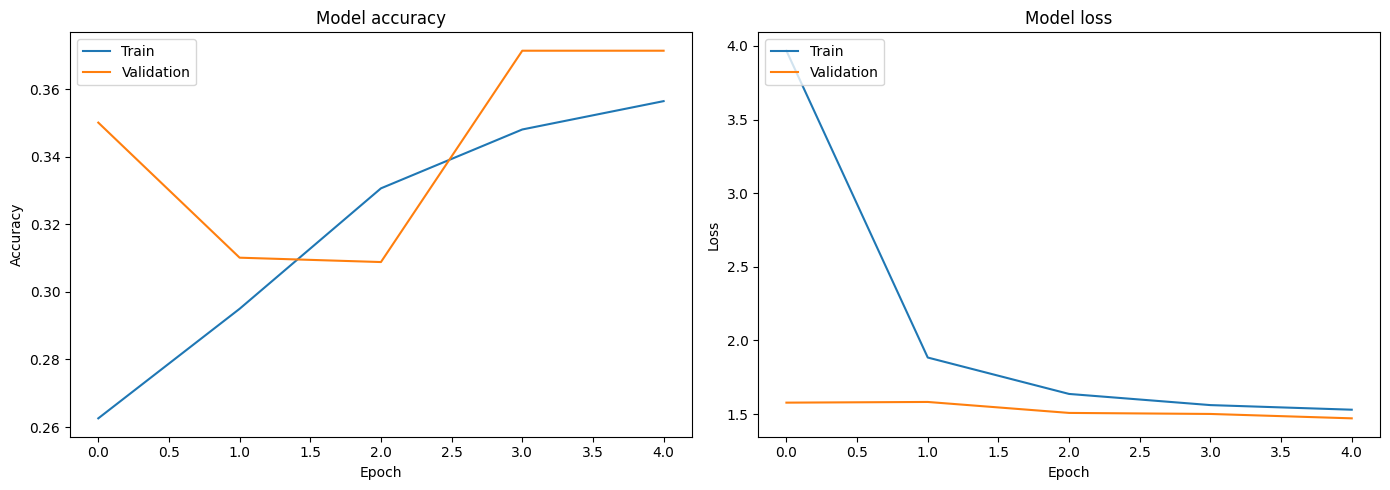

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


**ANN MODEL**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Assuming your preprocessed data is stored in X_train, y_train, X_test, y_test

# Build the ANN model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Input layer with 64 neurons
model.add(Dense(32, activation='relu'))  # Hidden layer with 32 neurons
model.add(Dense(16, activation='relu'))  # Another hidden layer with 16 neurons
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer with 1 neuron for binary classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3162 - loss: 2.9087 - val_accuracy: 0.3752 - val_loss: 1.5280
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4232 - loss: 1.4582 - val_accuracy: 0.5912 - val_loss: 1.2660
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5439 - loss: 1.2699 - val_accuracy: 0.6177 - val_loss: 1.0387
Epoch 4/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6052 - loss: 1.0401 - val_accuracy: 0.7092 - val_loss: 0.8856
Epoch 5/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6429 - loss: 0.8887 - val_accuracy: 0.7041 - val_loss: 0.7949
Epoch 6/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6675 - loss: 0.8346 - val_accuracy: 0.5803 - val_loss: 1.0103
Epoch 7/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7069 - loss: 0.7909 - val_accuracy: 0.7621 - val_loss: 0.7169
Epoch 8/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7138 - loss: 0.7656 - val_accuracy: 0.7782 - val_

In [ ]:
# Evaluate the model
ANN_loss, ANN_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {ANN_accuracy}')

# output model metrics
eval_model(X_train, y_train)

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7506 - loss: 0.6189
Test Accuracy: 0.7399380803108215
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model evaluation - Loss: 0.636417806148529, Accuracy: 0.7497097253799438
precision = 0.6116321098013126
recall = 0.5951383908029163
Confusion matrix on training data:
- x-axis is true labels.
- y-axis is predicted labels
    0     1    2     3    4
0  53    62  370     0  196
1  38  1748  176     3  146
2  45    11  938    45  397
3   0     4   56  2782   37
4   2   186  165     1  290


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


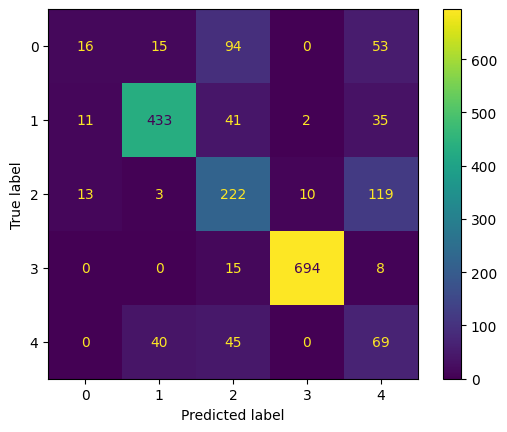

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_labels = y_pred.argmax(axis=1)
y_true_labels = y_test.argmax(axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

**A Basic Logistic Regression for Comparison**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Create a logistic regression model based on an OVR classifier
model = OneVsRestClassifier(LogisticRegression())

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
# OVR doesn't expose model.evaluate so have to use just accuracy on predictions
y_pred = model.predict(X_test)
LR_accuracy = accuracy_score(y_test, y_pred)



**Summary**

In [ ]:
print(f"Tuned ANN loss: {tuned_ann_score[0]}, accuracy: {tuned_ann_score[1]}")
print(f"LSTM loss: {LSTM_score[0]}, accuracy: {LSTM_score[1]}")
print(f"GRNN loss: {grnn_score[0]}, accuracy: {grnn_score[1]}")
print(f"ANN loss: {ANN_loss}, accuracy: {ANN_accuracy}")
print(f"LR accuracy: {LR_accuracy}")

Tuned ANN loss: 1.6667811870574951, accuracy: 0.3514385223388672
LSTM loss: 0.5676912665367126, accuracy: 0.7786377668380737
GRNN loss: 1.49161958694458, accuracy: 0.36996904015541077
ANN loss: 0.6397250294685364, accuracy: 0.7399380803108215
LR accuracy: 0.5789473684210527


**Follow-up and Refinement Opportunities**

We did extensive pre-processing and analysis, most of which was not included in this notebook.  Our focus here was to get data of reasonable quality to explore methods of building and measuring deep learning models and techniques.  We would continue to refine these models by:


1.   Performing thorough feature selection and dimensionality reduction
2.   Perform deeper analysis to identify and reduce outlier impact on models
3.   Explore ensemble and cross validation methods specific to neural networks

